In [1]:
%matplotlib inline

# Preprocessing and Spike Sorting Tutorial

## TODO: Add the preprocessing steps from https://github.com/SpikeInterface/spiketutorials/blob/master/Official_Tutorial_SI_0.94_May2022/SpikeInterface_Tutorial.ipynb

# Chapter 2: Preprocessing Recording

In [2]:
import os
import warnings
import glob
import pickle
import _pickle as cPickle
import importlib

In [3]:
from collections import defaultdict
import time
import json

In [4]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import pandas as pd
import scipy.signal

In [5]:
# Changing the figure size
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

The spikeinterface module by itself import only the spikeinterface.core submodule
which is not useful for end user



In [6]:
import spikeinterface

We need to import one by one different submodules separately (preferred).
There are 5 modules:

- :code:`extractors` : file IO
- :code:`toolkit` : processing toolkit for pre-, post-processing, validation, and automatic curation
- :code:`sorters` : Python wrappers of spike sorters
- :code:`comparison` : comparison of spike sorting output
- :code:`widgets` : visualization



In [7]:
import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import spikeinterface.preprocessing as sp

In [8]:
import spikeinterface.core

In [9]:
from probeinterface import get_probe
from probeinterface.plotting import plot_probe, plot_probe_group
from probeinterface import write_prb, read_prb

We can also import all submodules at once with this
  this internally import core+extractors+toolkit+sorters+comparison+widgets+exporters

This is useful for notebooks but this is a more heavy import because internally many more dependency
are imported (scipy/sklearn/networkx/matplotlib/h5py...)



In [10]:
import spikeinterface.full as si

In [11]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (10,6)

# Part 1: Importing Data

## Loading in the Electrophysiology Recording

- We are inputting the electrophsiology recording data with probe information. This should have been created in the prevous notebook in a directory created by Spike Interface. If you had already read in your own electrophsiology recording data with probe information with a different way, then follow these instructions.
    - If you want to use a different directory, then you must either:
        - Change `glob.glob({./path/to/with/*/recording_raw})` to the directory that you have the directories created from Spikeinterface. You can use a wildcard if you have multiple folders. You would replace `{./path/to/with/*/recording_raw}` with the path to either the parent directory or the actual directory containing the electrophsiology recording data read into Spikeinterface.
        - Or change `(file_or_folder_or_dict={./path/to/recording_raw})`. You would replace `{./path/to/recording_raw}` with the path to either the parent directory or the actual directory containing the electrophsiology recording data read into Spikeinterface.

In [12]:
all_recording_raw_directories = glob.glob("./proc/**/recording_raw", recursive=True)

In [13]:
all_recording_raw_directories

['./proc/20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3/recording_raw']

- If you have more than one recording directory, then you must either:
    - A. Put the index of the file in `all_recording_directories[0]` below. You would replace the `0` with the correct index. (Remember, Python is zero indexed so the first file in the list is 0. Second is 1, and so forth.
    - B. Add a absolute or relative path to `(file_or_folder_or_dict={./path/to/recording_file.rec}`) below. You would replace `{./path/to/recording_file.rec}` with the path of the file for the metadata.

In [14]:
# To be used when referencing the original raw recording
recording_raw = spikeinterface.core.load_extractor(file_or_folder_or_dict=all_recording_raw_directories[0])


## Metadata from the recording file

- This is how you retrieve info from a :code:`RecordingExtractor`...



In [15]:
channel_ids = recording_raw.get_channel_ids()
fs = recording_raw.get_sampling_frequency()
num_chan = recording_raw.get_num_channels()
num_seg = recording_raw.get_num_segments()
duration = recording_raw.get_num_frames()

print('Channel ids:', channel_ids)
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)
print('Number of segments:', num_seg)
print('Duration:', duration)
print('Number of hours:', duration/fs/3600)

Channel ids: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '30' '31']
Sampling frequency: 20000.0
Number of channels: 32
Number of segments: 1
Duration: 64113600
Number of hours: 0.8904666666666666


- Looking over the probe

In [16]:
probe_object = recording_raw.get_probegroup()

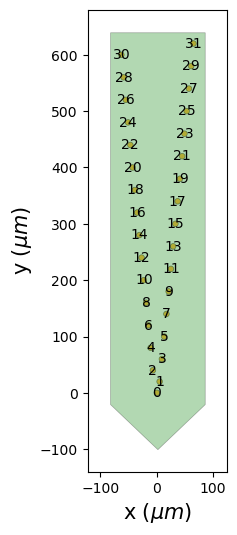

In [17]:
plot_probe_group(probe_object, same_axes=False, with_channel_index=True)
plt.show()

# Part 2: Preprocessing

- Preproccessing the signal to improve the spike sorting performance

- **NOTE**: If you want to add preprocessing steps, you must either make additional code cells to a similar format as below or change the `Raw NBConvert` cells into `Code` cells.
    - Here are more available steps: https://spikeinterface.readthedocs.io/en/latest/modules/preprocessing/plot_1_preprocessing.html#sphx-glr-modules-preprocessing-plot-1-preprocessing-py
- **NOTE**: If you want to remove preprocessing steps, you must turn unneeded `Code` cells into `Raw NBConvert` cells.
- **NOTE**: If you want to reorder the preprocessing steps, you must reorder the `Code` cells by clicking on the up or down arrow on the top menu when you have the `Code` cell clicked.

- All available preprocessing methods shown below:

In [18]:
for method in dir(spikeinterface.preprocessing):
    print(method)


AlignSnippets
BandpassFilterRecording
BlankSaturationRecording
CenterRecording
ClipRecording
CommonReferenceRecording
DeepInterpolatedRecording
FilterRecording
HighpassFilterRecording
HighpassSpatialFilterRecording
InterpolateBadChannelsRecording
NormalizeByQuantileRecording
NotchFilterRecording
PhaseShiftRecording
RectifyRecording
RemoveArtifactsRecording
ResampleRecording
ScaleRecording
WhitenRecording
ZScoreRecording
ZeroChannelPaddedRecording
__builtins__
__cached__
__doc__
__file__
__loader__
__name__
__package__
__path__
__spec__
align_snippets
bandpass_filter
basepreprocessor
blank_staturation
center
clip
common_reference
correct_lsb
deepinterpolate
deepinterpolation
detect_bad_channels
filter
get_spatial_interpolation_kernel
highpass_filter
highpass_spatial_filter
installed_preprocessers_list
interpolate_bad_channels
normalize_by_quantile
normalize_scale
notch_filter
phase_shift
preprocesser_dict
preprocessers_full_list
preprocessing_tools
preprocessinglist
rectify
remove_artif

In [19]:
preprocessing_step_dict = defaultdict(dict)

In [20]:
preprocessing_step_dict["recording_raw"] = recording_raw

In [21]:
# To be used for all steps
recording_intermediate = recording_raw

In [22]:
# Bandpass Filtering, keeping all the points that are within a certain frequency range
recording_bandpass = sp.bandpass_filter(recording_intermediate, freq_min=0.01, freq_max=300)
recording_intermediate = sp.bandpass_filter(recording_intermediate, freq_min=0.01, freq_max=300)
preprocessing_step_dict["recording_bandpass"] = recording_bandpass
print(recording_bandpass)

BandpassFilterRecording: 32 channels - 1 segments - 20.0kHz - 3205.680s


In [23]:
# Bandpass Filtering, keeping all the points that are within a certain frequency range
recording_notch = sp.notch_filter(recording_intermediate, freq=60)
recording_intermediate = sp.notch_filter(recording_intermediate, freq=60)
preprocessing_step_dict["recording_notch"] = recording_bandpass
print(recording_bandpass)

BandpassFilterRecording: 32 channels - 1 segments - 20.0kHz - 3205.680s


In [24]:
# Resampling
recording_resample = spikeinterface.preprocessing.resample(recording_intermediate, resample_rate=1000)
recording_intermediate = spikeinterface.preprocessing.resample(recording_intermediate, resample_rate=1000)
preprocessing_step_dict["recording_resample"] = recording_resample
print(recording_resample)

ResampleRecording: 32 channels - 1 segments - 1.0kHz - 3205.680s


In [25]:
preprocessing_step_dict

defaultdict(dict,
            {'recording_raw': BinaryFolderRecording: 32 channels - 1 segments - 20.0kHz - 3205.680s,
             'recording_bandpass': BandpassFilterRecording: 32 channels - 1 segments - 20.0kHz - 3205.680s,
             'recording_notch': BandpassFilterRecording: 32 channels - 1 segments - 20.0kHz - 3205.680s,
             'recording_resample': ResampleRecording: 32 channels - 1 segments - 1.0kHz - 3205.680s})

# Part 3: Visualization and EDA

## Plotting the Time Series

- Plotting with lines are better for recordings with smaller channel numbers

In [26]:
time_difference = 1

In [27]:
start_time = int(300)

In [28]:
time_range = [start_time, start_time + time_difference] 

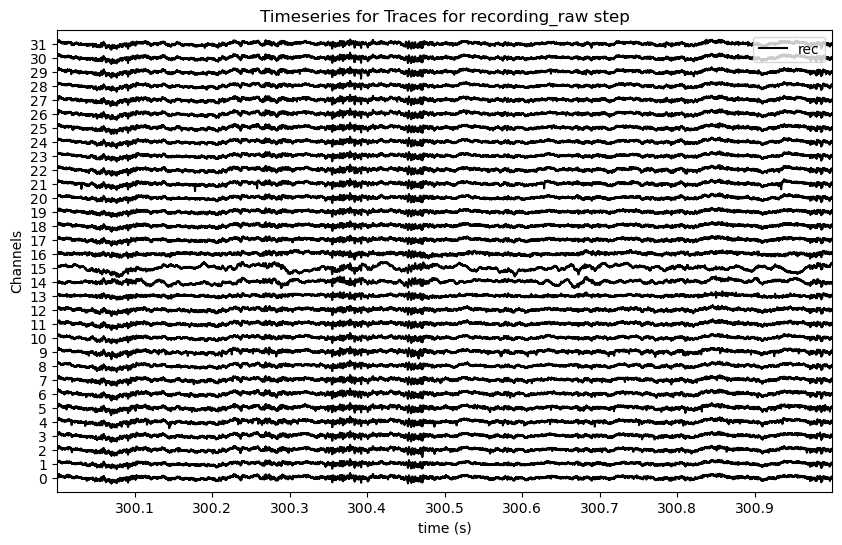

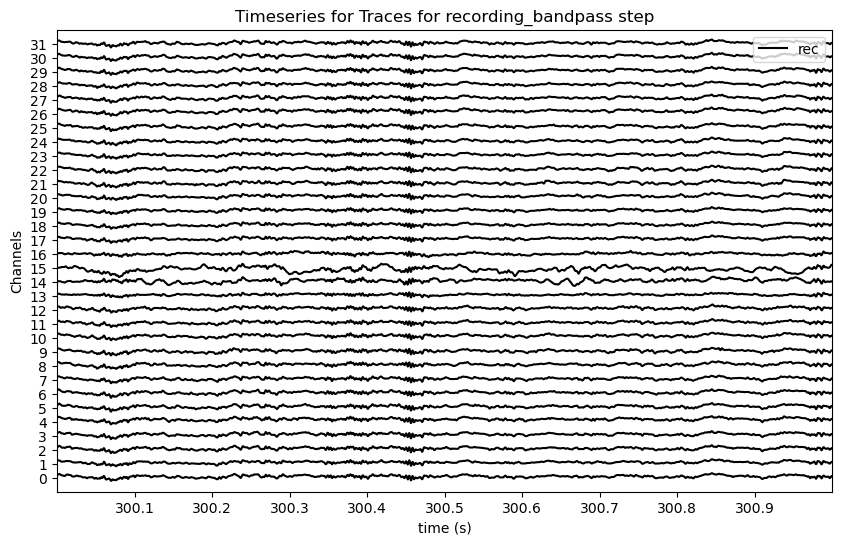

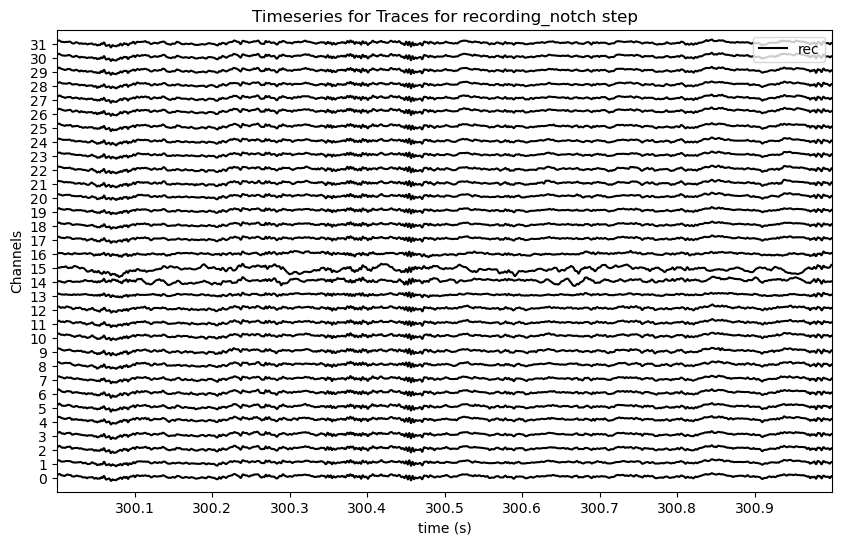

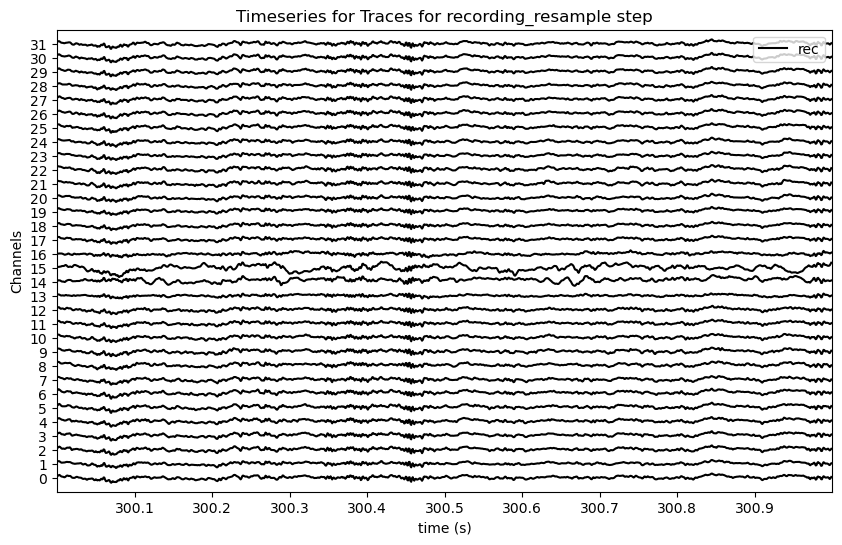

In [29]:
for key, value in preprocessing_step_dict.items():
    sw.plot_timeseries(value, time_range=(time_range[0], time_range[1]), show_channel_ids=True) #, figure=fig)
    plt.title("Timeseries for Traces for {} step".format(key))
    plt.ylabel("Channels")
    plt.show()

- Looking more closely at a few of the channels
    - The Channel IDs:

In [30]:
recording_intermediate.channel_ids

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31'], dtype='<U2')

In [31]:
channel_ids = np.random.choice(recording_intermediate.channel_ids, size=5, replace=False)

In [32]:
channel_ids = sorted(channel_ids, key=lambda x: float(x))

In [33]:
channel_ids

['2', '4', '14', '24', '29']

- If you want to use a specific set of channels, change the channels in the cell below and turn it into a `Code` cell

In [34]:
# Best channels with current setup
channel_ids = ["31", "17", "16", "15", "13"]

- With Raw Recording

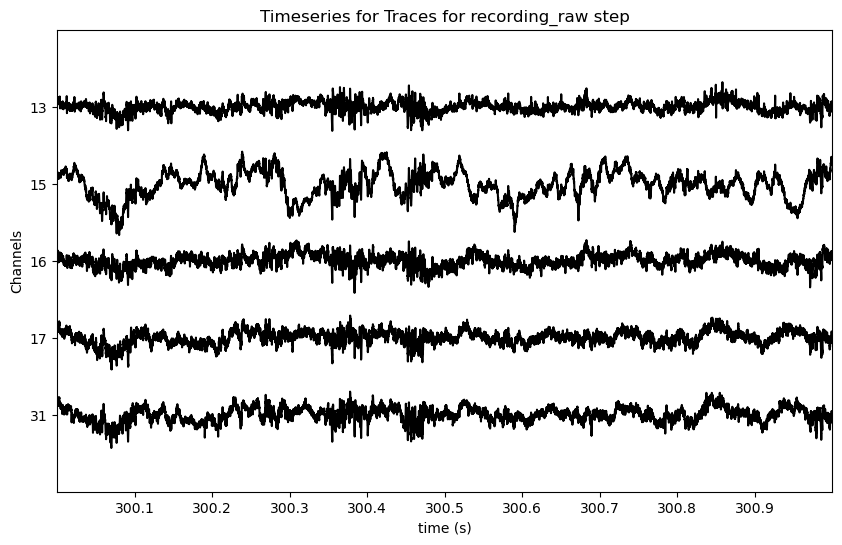

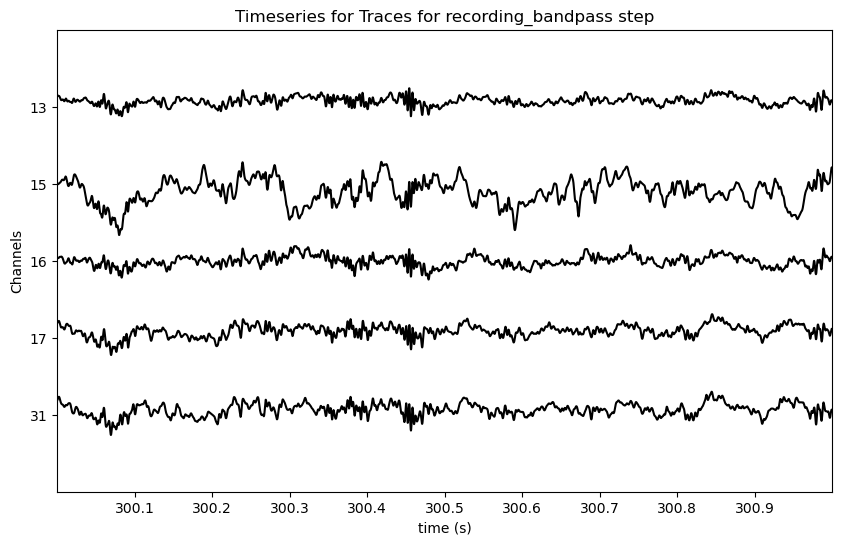

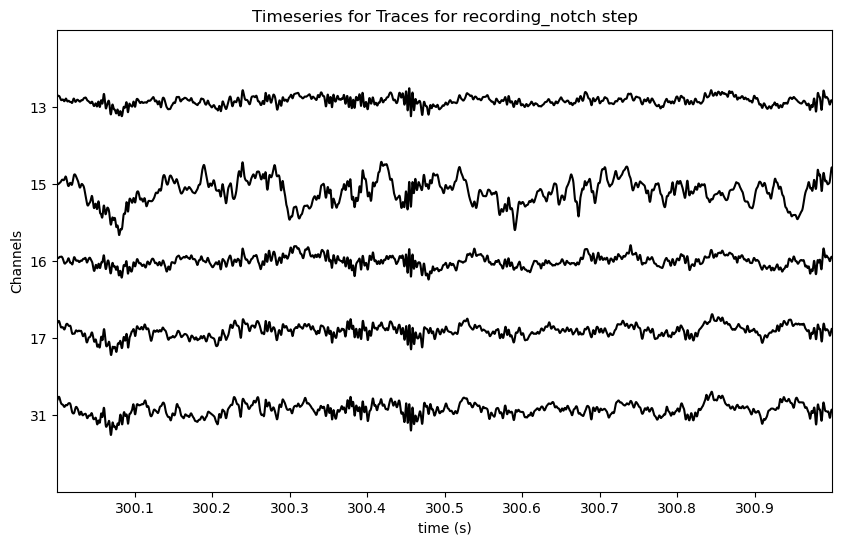

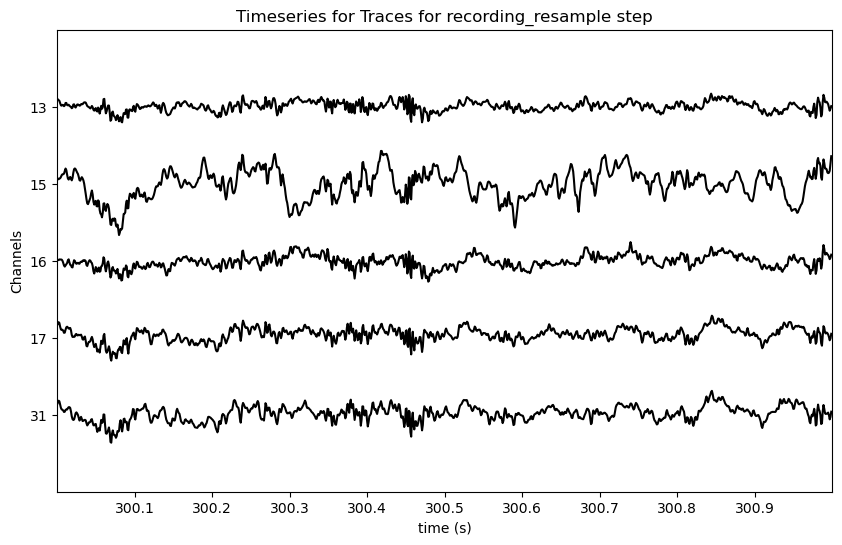

In [35]:
for key, value in preprocessing_step_dict.items():
    sw.plot_timeseries(value, time_range=time_range, channel_ids=channel_ids, show_channel_ids=True)
    plt.title("Timeseries for Traces for {} step".format(key))
    plt.ylabel("Channels")
    plt.legend().remove()
    plt.show()

# Looking at the Frequency to Power

In [36]:
from spectral_connectivity import Multitaper, Connectivity


In [37]:
import pandas as pd

In [38]:
raise ValueError()

ValueError: 

### Omission and Rewarded Trials

In [41]:
tone_label_df = pd.read_csv("./proc/20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3_tone_label_df.csv", index_col=0)

In [42]:
tone_label_df

,tone_time_stamp,tone_category,tone_clock_time_omission,tone_clock_time_comp
0,1408048,rewarded,60.40240,-1269.52745
1,3008051,rewarded,140.40255,-1189.52730
2,4808043,rewarded,230.40215,-1099.52770
3,6408042,omission,310.40210,-1019.52775
4,7908040,rewarded,385.40200,-944.52785
5,9908037,rewarded,485.40185,-844.52800
6,11808035,rewarded,580.40175,-749.52810
7,13608031,rewarded,670.40155,-659.52830
8,15208032,omission,750.40160,-579.52825
9,17008029,rewarded,840.40145,-489.52840


- Adding a column for 

In [45]:
resampled_frequency / recording_raw.sampling_frequency

NameError: name 'resampled_frequency' is not defined

### Competition Trials

In [ ]:
# Compute multitaper spectral estimate
m = Multitaper(time_series=recording_intermediate.get_traces(channel_ids=["21"]))

# Sets up computing connectivity measures/power from multitaper spectral estimate
c = Connectivity.from_multitaper(m)

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("Frequency")
ax.set_ylabel("Power")
ax.plot(c.frequencies, c.power().squeeze())
ax.set_xlim(0,20)

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("Frequency")
ax.set_ylabel("Power")
ax.plot(c.frequencies, c.power().squeeze())
ax.set_xlim(20,40)
ax.set_ylim(0,2000)

In [ ]:

    plt.rcParams["figure.figsize"] = (14,10)
    fig, ax = plt.subplots()



    ax.plot(frequencies, baseline_channel_to_trial_to_power[channel][trial_type]["mean_traces_array"], label="-4s to 0s\n{}".format(trial_type.capitalize()), linestyle="--", color=trial_type_to_color[trial_type], linewidth = LINWID)
#     ax.fill_between(frequencies, baseline_channel_to_trial_to_power[channel][trial_type]["mean_traces_array"]-baseline_channel_to_trial_to_power[channel][trial_type]["ste_traces_array"], \
#                         baseline_channel_to_trial_to_power[channel][trial_type]["mean_traces_array"]+baseline_channel_to_trial_to_power[channel][trial_type]["ste_traces_array"], \
#                        alpha=.25, color=trial_type_to_color[trial_type])
        
    ax.set_xlabel("Frequency(Hz)", fontsize = AXESLABEL)
    ax.set_ylabel("Power", fontsize = AXESLABEL)
    plt.xticks(fontsize = AXESTICKS, family="Arial")
    plt.yticks(fontsize = AXESTICKS, family="Arial")

    
#     ax.set_xlim(0,12)
    ax.set_ylim(0,brain_region_to_ylim[channel_id_to_brain_region[channel]])




   plt.show()


# Part 4: Saving the Preprocessed files to folder

- Seeing which recording directories are already made

In [ ]:
all_parent_recording_directories = glob.glob("./proc/*")

In [ ]:
all_parent_recording_directories

- If you have more than one recording directory, then you must either:
    - A. Put the index of the file in `all_recording_directories[0]` below. You would replace the `0` with the correct index. (Remember, Python is zero indexed so the first file in the list is 0. Second is 1, and so forth.
    - B. Add a absolute or relative path to `(file_or_folder_or_dict={./path/to/recording_file.rec}`) below. You would replace `{./path/to/recording_file.rec}` with the path of the file for the metadata.

In [ ]:
parent_output_directory = all_parent_recording_directories[0]

- Creating a directory within the recording directory for preprocessing and saving the preprocessed recordings into it 

In [ ]:
preprocessing_output_directory = os.path.join(parent_output_directory, "preprocessing")


In [ ]:
if not os.path.exists(preprocessing_output_directory):
    recording_intermediate.save_to_folder(name="preprocessing", folder=preprocessing_output_directory)
else:
    warnings.warn("""Directory already exists for: {}. 
    Either continue on if you are satisfied with the previous run 
    or delete the directory and run this cell again""".format(preprocessing_output_directory))

- Testing to see if everything was loaded correctly

In [ ]:
recording_test = spikeinterface.core.load_extractor(file_or_folder_or_dict=preprocessing_output_directory)


In [ ]:
sw.plot_timeseries(recording_test, time_range=time_range, channel_ids=channel_ids, show_channel_ids=True)


In [ ]:
probe_group = recording_test.get_probegroup()

In [ ]:
plot_probe_group(probe_group, same_axes=False, with_channel_index=True)
plt.show()